In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cvxpy as cp
import cvxpylayers
from cvxpylayers.torch import CvxpyLayer
#from algorithms import fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from latexify import latexify
cp.__version__, cvxpylayers.__version__

('1.4.3', '0.1.6')

In [8]:
torch.set_default_dtype(torch.double)


def fit(loss, params, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
        Y: output data, torch tensor.
        Xval: input validation data, torch tensor.
        Yval: output validation data, torch tensor.
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = opt(params, **opt_kwargs)

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose:
            print("%03d | %3.5f" % (epoch + 1, val_losses[-1]))
        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
            if callback is not None:
                callback()
    return val_losses, train_losses

In [9]:
# Define convex optimization model
m = 10

y = cp.Variable(m)
units = cp.Variable(m)
t = cp.Variable(m)
alpha = cp.Parameter(m, nonneg=True)
inverse_p = cp.Parameter(m, nonneg=True)
B = cp.Parameter(nonneg=True)

objective = cp.sum(t)
constraints = [cp.sum(y) == B, y >= 0,
               -cp.exp(-cp.multiply(alpha, units)) >= cp.multiply(alpha, t),
               units == cp.multiply(y, inverse_p)]
prob = cp.Problem(cp.Maximize(objective), constraints)
layer = CvxpyLayer(prob, [B, inverse_p, alpha], [y])

In [16]:
# Get data
def get_data(N, m, alpha):
    P = torch.rand(N, m)
    B = torch.rand(N) * 10
    Y = layer(B, 1 / P, alpha)[0]
    Y = Y * (torch.rand_like(Y) + .5)
    Y = Y * B[:,None] / Y.sum(1)[:,None]
    return torch.cat([B.unsqueeze(1), P], axis=1), Y

torch.manual_seed(0)
alpha_true = torch.rand(m)
X, Y = get_data(100, m, alpha_true)
Xval, Yval = get_data(50, m, alpha_true)
Y[:3]


tensor([[ 2.9211e-01,  4.5317e-01,  9.4326e-01,  1.9860e-01,  7.3760e-01,
          3.1331e-01,  1.3644e+00,  4.8556e-01,  5.5352e-01,  5.6664e-01],
        [ 1.3086e-01, -4.1931e-05,  3.7348e-01, -3.0877e-05,  2.2688e-01,
         -5.1202e-05, -2.3125e-05, -4.3233e-05, -3.0287e-05,  3.0717e-01],
        [ 3.2712e-01,  6.7103e-01,  6.5382e-01,  5.6061e-01,  8.3934e-01,
          3.0428e-01,  2.0330e+00,  9.8292e-01,  4.8010e-01,  2.0591e+00]])

In [11]:
loss_fn = torch.nn.MSELoss()

In [12]:
torch.manual_seed(1)
alpha = torch.rand(m)
alpha.requires_grad_(True)
def loss(X, Y, alpha):
    Yhat = layer(X[:,0], 1. / X[:,1:], alpha)[0]
    return loss_fn(Y, Yhat)

def callback():
    alpha.data = torch.max(alpha.data, torch.zeros_like(alpha.data))

print(loss(X, Y, alpha_true), loss(Xval, Yval, alpha_true))
print(loss(X, Y, alpha), loss(Xval, Yval, alpha))

val_losses, train_losses = fit(lambda X, Y: loss(X, Y, alpha), [alpha], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr":1e-2},
                               batch_size=4, epochs=25, verbose=True, callback=callback)

tensor(0.0321) tensor(0.0282)
tensor(0.8471, grad_fn=<MseLossBackward0>) tensor(0.7305, grad_fn=<MseLossBackward0>)


C:\Users\kenfe\PycharmProjects\Day_ahead-bidding-strategy\.venv\Lib\site-packages\threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


001 | 0.73050
batch 001 / 025 | 1.00043
batch 002 / 025 | 0.87484
batch 003 / 025 | 0.64939
batch 004 / 025 | 0.73829
batch 005 / 025 | 0.73778
batch 006 / 025 | 0.72300
batch 007 / 025 | 0.67919
batch 008 / 025 | 0.64925
batch 009 / 025 | 0.66411
batch 010 / 025 | 0.64368
batch 011 / 025 | 0.63334
batch 012 / 025 | 0.64231
batch 013 / 025 | 0.60525
batch 014 / 025 | 0.59144
batch 015 / 025 | 0.57272
batch 016 / 025 | 0.54328
batch 017 / 025 | 0.54649
batch 018 / 025 | 0.52870
batch 019 / 025 | 0.52619
batch 020 / 025 | 0.51533
batch 021 / 025 | 0.50635
batch 022 / 025 | 0.49704
batch 023 / 025 | 0.48247
batch 024 / 025 | 0.46780
batch 025 / 025 | 0.45579
002 | 0.18805
batch 001 / 025 | 0.22088
batch 002 / 025 | 0.21309
batch 003 / 025 | 0.19414
batch 004 / 025 | 0.18903
batch 005 / 025 | 0.20340
batch 006 / 025 | 0.19193
batch 007 / 025 | 0.17758
batch 008 / 025 | 0.17941
batch 009 / 025 | 0.16653
batch 010 / 025 | 0.17540
batch 011 / 025 | 0.18614
batch 012 / 025 | 0.17817
batch 013 

In [13]:
theta = torch.zeros(m + 1, m)
theta0 = torch.zeros(m, requires_grad=True)
theta.requires_grad_(True)
opt = torch.optim.LBFGS([theta, theta0], max_iter=500)
l = torch.nn.KLDivLoss()

def closure():
    opt.zero_grad()
    loss = l(torch.nn.LogSoftmax()(X @ theta + theta0), Y / Y.sum(1)[:,None])
    loss.backward()
    return loss

opt.step(closure)

C:\Users\kenfe\PycharmProjects\Day_ahead-bidding-strategy\.venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
C:\Users\kenfe\PycharmProjects\Day_ahead-bidding-strategy\.venv\Lib\site-packages\torch\nn\functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(nan, grad_fn=<MeanBackward0>)

C:\Users\kenfe\PycharmProjects\Day_ahead-bidding-strategy\.venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: 'figures/resource_allocation.pdf'

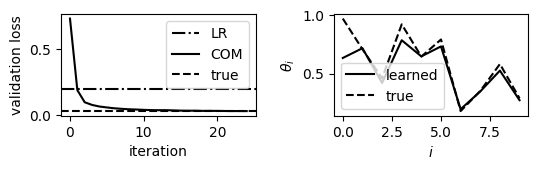

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(5.485, 1.8)

ax[0].axhline(loss_fn(torch.nn.Softmax()(Xval @ theta + theta0) * Xval[:,0][:,None], Yval).item(), linestyle='-.', c='black', label='LR')
ax[0].plot(val_losses, c='black', label='COM')
ax[0].axhline(loss(Xval, Yval, alpha_true).item(), linestyle='--', c='black', label='true')
ax[0].legend()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("validation loss")

ax[1].plot(alpha.detach().numpy(), c='black', label='learned')
ax[1].plot(alpha_true.detach().numpy(), '--', c='black', label='true')
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("$\\theta_i$")
ax[1].legend()

plt.tight_layout()

#plt.savefig("figures/resource_allocation.pdf")